### Dependencies

In [1]:
!pip install keras-rectified-adam
!pip install segmentation-models

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=6a0f1419de220ba11326fbc4d71090987929c2d48a056758174367a20e2bf41e
  Stored in directory: /tmp/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 


In [2]:
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import albumentations as albu
from keras_radam import RAdam
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [3]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])
test['set'] = 'test'

display(X_train.head())

Compete set samples: 22184
Train samples:  4436
Validation samples:  1110
Test samples: 14792


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,set
0,c9629d8.jpg,NaN,1082202 658 1083602 658 1085002 658 1086402 65...,1134924 476 1136324 476 1137724 476 1139124 47...,1674 417 3074 417 4474 417 5874 417 7274 417 8...,train
1,e8e25ab.jpg,239 463 1639 463 3039 463 4439 463 5839 463 72...,1029006 350 1030406 350 1031806 350 1033206 35...,NaN,5606 574 7006 574 8406 574 9806 574 11206 574 ...,train
2,31c1874.jpg,959762 410 961162 410 962562 410 963962 410 96...,751962 1228 753362 1228 754762 1228 756162 122...,NaN,NaN,train
3,a396614.jpg,NaN,NaN,17941 239 19341 239 20741 239 22141 239 23541 ...,3030 665 4430 665 5830 665 7230 665 8574 1226 ...,train
4,560dedf.jpg,6555 444 7955 444 8437 897 9355 444 9837 897 1...,NaN,NaN,1409 644 2809 644 4209 644 5609 644 7009 644 8...,train


# Model parameters

In [4]:
BACKBONE = 'resnet152'
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 3e-4
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
model_path = '../working/uNet_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)

In [5]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.RandomRotate90(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, border_mode=0, p=0.5),
                             albu.OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5)
                            ])

### Auxiliary functions

In [6]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['image']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, train_base_path, train_images_dest_path)
        if item_set == 'validation':
            preprocess_image(image_id, train_base_path, validation_images_dest_path)
        if item_set == 'test':
            preprocess_image(image_id, test_base_path, test_images_dest_path)
            
def get_metrics(model, df, df_images_dest_path, tresholds, min_mask_sizes, set_name='Complete set'):
    class_names = ['Fish', 'Flower', 'Gravel', 'Sugar']
    metrics = []

    for class_name in class_names:
        metrics.append([class_name, 0, 0])

    metrics_df = pd.DataFrame(metrics, columns=['Class', 'Dice', 'Dice Post'])
    
    for i in range(0, df.shape[0], 500):
        batch_idx = list(range(i, min(df.shape[0], i + 500)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=train,
                      batch_size=len(batch_set), 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)
        
        for class_index in range(N_CLASSES):
            class_score = []
            class_score_post = []
            mask_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for index in range(len(batch_idx)):
                sample_mask = mask_class[index, ]
                sample_pred = pred_class[index, ]
                sample_pred_post = post_process(sample_pred, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                    dice_score = 1.
                else:
                    dice_score = dice_coefficient(sample_pred, sample_mask)
                if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                    dice_score_post = 1.
                else:
                    dice_score_post = dice_coefficient(sample_pred_post, sample_mask)
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            metrics_df.loc[metrics_df['Class'] == class_names[class_index], 'Dice'] += np.mean(class_score) * ratio
            metrics_df.loc[metrics_df['Class'] == class_names[class_index], 'Dice Post'] += np.mean(class_score_post) * ratio

    metrics_df = metrics_df.append({'Class':set_name, 'Dice':np.mean(metrics_df['Dice'].values), 'Dice Post':np.mean(metrics_df['Dice Post'].values)}, ignore_index=True).set_index('Class')
    
    return metrics_df

def plot_metrics(history):
    fig, axes = plt.subplots(4, 1, sharex='col', figsize=(22, 14))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(history['iou_score'], label='Train IOU Score')
    axes[1].plot(history['val_iou_score'], label='Validation IOU Score')
    axes[1].legend(loc='best')
    axes[1].set_title('IOU Score')

    axes[2].plot(history['dice_coef'], label='Train Dice coefficient')
    axes[2].plot(history['val_dice_coef'], label='Validation Dice coefficient')
    axes[2].legend(loc='best')
    axes[2].set_title('Dice coefficient')

    axes[3].plot(history['score'], label='Train F-Score')
    axes[3].plot(history['val_score'], label='Validation F-Score')
    axes[3].legend(loc='best')
    axes[3].set_title('F-Score')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()
    
def pre_process_set(df, preprocess_fn):
    n_cpu = mp.cpu_count()
    df_n_cnt = df.shape[0]//n_cpu
    pool = mp.Pool(n_cpu)
    
    dfs = [df.iloc[df_n_cnt*i:df_n_cnt*(i+1)] for i in range(n_cpu)]
    dfs[-1] = df.iloc[df_n_cnt*(n_cpu-1):]
    res = pool.map(preprocess_fn, [x_df for x_df in dfs])
    pool.close()
    
def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """
    Cosine decay schedule with warm up period.
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    :param global_step {int}: global step.
    :param learning_rate_base {float}: base learning rate.
    :param total_steps {int}: total number of training steps.
    :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
    :param warmup_steps {int}: number of warmup steps. (default: {0}).
    :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
    :param global_step {int}: global step.
    :Returns : a float representing learning rate.
    :Raises ValueError: if warmup_learning_rate is larger than learning_rate_base, or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(Callback):
    """Cosine decay with warmup learning rate scheduler"""

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """
        Constructor for cosine decay with warmup learning rate scheduler.
        :param learning_rate_base {float}: base learning rate.
        :param total_steps {int}: total number of training steps.
        :param global_step_init {int}: initial global step, e.g. from previous checkpoint.
        :param warmup_learning_rate {float}: initial learning rate for warm up. (default: {0.0}).
        :param warmup_steps {int}: number of warmup steps. (default: {0}).
        :param hold_base_rate_steps {int}: Optional number of steps to hold base learning rate before decaying. (default: {0}).
        :param verbose {int}: quiet, 1: update messages. (default: {0}).
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %02d: setting learning rate to %s.' % (self.global_step + 1, lr))

## Pre-process data

In [7]:
train_base_path = '../input/understanding_cloud_organization/train_images/'
test_base_path = '../input/understanding_cloud_organization/test_images/'
train_images_dest_path = 'base_dir/train_images/'
validation_images_dest_path = 'base_dir/validation_images/'
test_images_dest_path = 'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_images_dest_path)
os.makedirs(validation_images_dest_path)
os.makedirs(test_images_dest_path)

# Pre-procecss train set
pre_process_set(X_train, preprocess_data)

# Pre-procecss validation set
pre_process_set(X_val, preprocess_data)

# Pre-procecss test set
pre_process_set(test, preprocess_data)

### Data generator

In [8]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, target_df=None, mode='fit', directory=train_images_dest_path,
                 batch_size=BATCH_SIZE, n_channels=CHANNELS, target_size=(HEIGHT, WIDTH), 
                 n_classes=N_CLASSES, seed=seed, shuffle=True, preprocessing=None, augmentation=None):
        
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.mode = mode
        self.directory = directory
        self.target_df = target_df
        self.target_size = target_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.seed = seed
        self.mask_shape = (1400, 2100)
        self.list_IDs = self.dataframe.index
        
        if self.seed is not None:
            np.random.seed(self.seed)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_Y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.target_size, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            img_path = self.directory + img_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.preprocessing:
                img = self.preprocessing(img)
                
            X[i,] = img

        return X
    
    def __generate_Y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.target_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == img_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.target_size)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, X_batch, Y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], Y_batch[i, ] = self.__random_transform(X_batch[i, ], Y_batch[i, ])
        
        return X_batch, Y_batch
    
    def __random_transform(self, X, Y):
        composed = self.augmentation(image=X, mask=Y)
        X_aug = composed['image']
        Y_aug = composed['mask']
        
        return X_aug, Y_aug
    
train_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [9]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

234332160/234326024 [==============================] - 14s 0us/step
Model: "u-resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
____________________

In [10]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15
 - 251s - loss: 1.4695 - dice_coef: 0.2549 - iou_score: 0.1170 - score: 0.1825 - val_loss: 1.4937 - val_dice_coef: 0.2450 - val_iou_score: 0.1160 - val_score: 0.1833
Epoch 2/15
 - 195s - loss: 1.2675 - dice_coef: 0.3095 - iou_score: 0.1334 - score: 0.2021 - val_loss: 1.3934 - val_dice_coef: 0.2852 - val_iou_score: 0.1294 - val_score: 0.1990
Epoch 3/15
 - 199s - loss: 1.1681 - dice_coef: 0.3482 - iou_score: 0.1428 - score: 0.2130 - val_loss: 1.2043 - val_dice_coef: 0.3250 - val_iou_score: 0.1413 - val_score: 0.2139
Epoch 4/15
 - 205s - loss: 1.1189 - dice_coef: 0.3771 - iou_score: 0.1494 - score: 0.2202 - val_loss: 1.1164 - val_dice_coef: 0.3829 - val_iou_score: 0.1579 - val_score: 0.2311
Epoch 5/15
 - 205s - loss: 1.0910 - dice_coef: 0.4054 - iou_score: 0.1584 - score: 0.2300 - val_loss: 1.4294 - val_dice_coef: 0.3935 - val_iou_score: 0.1573 - val_score: 0.2291
Epoch 6/15
 - 226s - loss: 1.0751 - dice_coef: 0.4215 - iou_score: 0.1643 - score: 0.2361 - val_loss: 1.0899 - val_

## Model loss graph

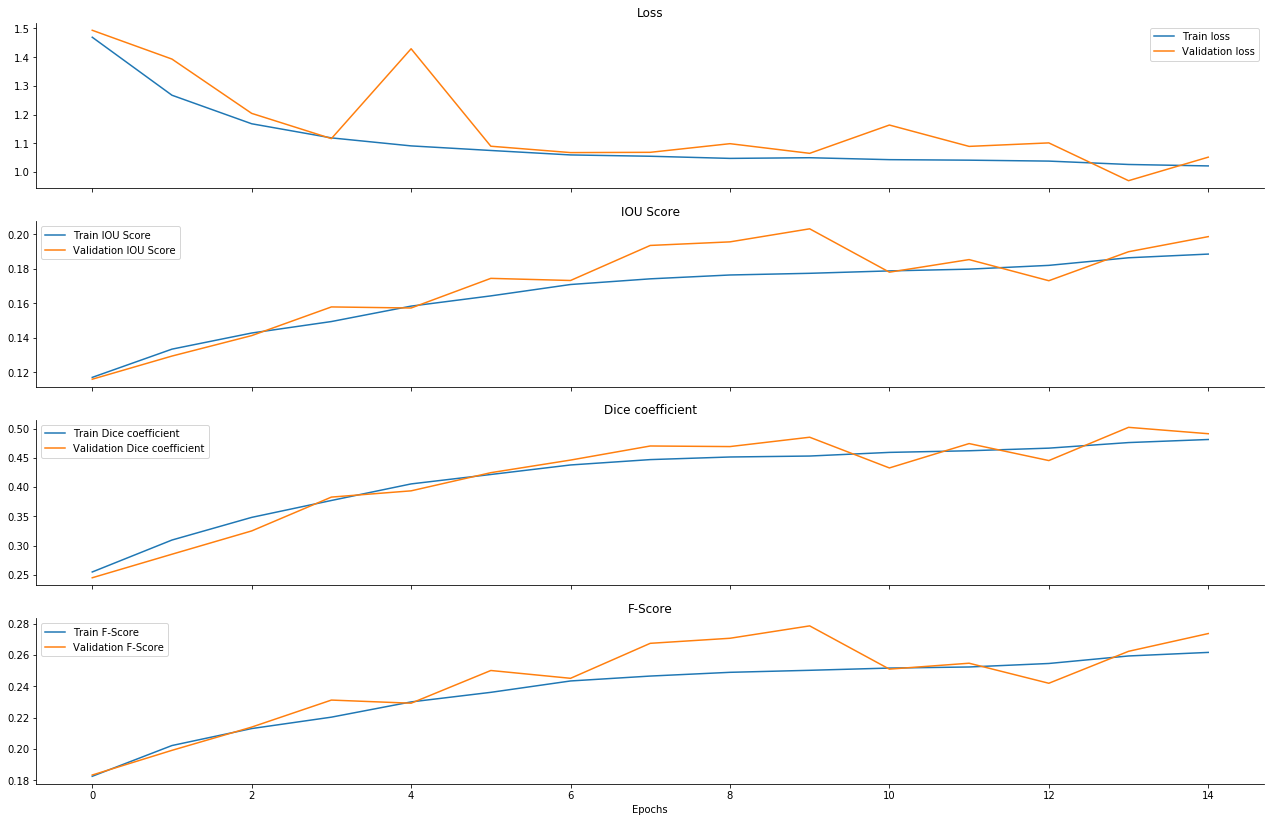

In [11]:
plot_metrics(history)

# Threshold and mask size tunning

In [12]:
class_names = ['Fish  ', 'Flower', 'Gravel', 'Sugar ']
mask_grid = [0, 500, 1000, 5000, 7500, 10000, 15000]
threshold_grid = np.arange(.5, 1, .05)
metrics = []

for class_index in range(N_CLASSES):
    for threshold in threshold_grid:
        for mask_size in mask_grid:
            metrics.append([class_index, threshold, mask_size, 0])

metrics_df = pd.DataFrame(metrics, columns=['Class', 'Threshold', 'Mask size', 'Dice'])

for i in range(0, X_val.shape[0], 500):
    batch_idx = list(range(i, min(X_val.shape[0], i + 500)))
    batch_set = X_val[batch_idx[0]: batch_idx[-1]+1]
    ratio = len(batch_set) / len(X_val)
    
    generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=batch_set,
                  target_df=train,
                  batch_size=len(batch_set), 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed,
                  mode='fit',
                  shuffle=False)
    
    x, y = generator.__getitem__(0)
    preds = model.predict(x)

    for class_index in range(N_CLASSES):
        class_score = []
        label_class = y[..., class_index]
        pred_class = preds[..., class_index]
        for threshold in threshold_grid:
            for mask_size in mask_grid:
                mask_score = []
                for index in range(len(batch_idx)):
                    label_mask = label_class[index, ]
                    pred_mask = pred_class[index, ]
                    pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                    dice_score = dice_coefficient(pred_mask, label_mask)
                    if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                        dice_score = 1.
                    mask_score.append(dice_score)
                metrics_df.loc[(metrics_df['Class'] == class_index) & (metrics_df['Threshold'] == threshold) & 
                               (metrics_df['Mask size'] == mask_size), 'Dice'] += np.mean(mask_score) * ratio

metrics_df_0 = metrics_df[metrics_df['Class'] == 0]
metrics_df_1 = metrics_df[metrics_df['Class'] == 1]
metrics_df_2 = metrics_df[metrics_df['Class'] == 2]
metrics_df_3 = metrics_df[metrics_df['Class'] == 3]

optimal_values_0 = metrics_df_0.loc[metrics_df_0['Dice'].idxmax()].values
optimal_values_1 = metrics_df_1.loc[metrics_df_1['Dice'].idxmax()].values
optimal_values_2 = metrics_df_2.loc[metrics_df_2['Dice'].idxmax()].values
optimal_values_3 = metrics_df_3.loc[metrics_df_3['Dice'].idxmax()].values

best_tresholds = [optimal_values_0[1], optimal_values_1[1], optimal_values_2[1], optimal_values_3[1]]
best_masks = [optimal_values_0[2], optimal_values_1[2], optimal_values_2[2], optimal_values_3[2]]
best_dices = [optimal_values_0[3], optimal_values_1[3], optimal_values_2[3], optimal_values_3[3]]

for index, name in enumerate(class_names):
    print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))

Fish   treshold=0.70 mask size=7500 Dice=0.592
Flower treshold=0.50 mask size=7500 Dice=0.740
Gravel treshold=0.55 mask size=7500 Dice=0.582
Sugar  treshold=0.50 mask size=5000 Dice=0.569


# Model evaluation

In [13]:
train_metrics = get_metrics(model, X_train, train_images_dest_path, best_tresholds, best_masks, 'Train')
display(train_metrics)

validation_metrics = get_metrics(model, X_val, validation_images_dest_path, best_tresholds, best_masks, 'Validation')
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.214878,0.611545
Flower,0.196685,0.767726
Gravel,0.218625,0.597948
Sugar,0.248951,0.585374
Train,0.219785,0.640648


,Dice,Dice Post
Class,,
Fish,0.213672,0.591930
Flower,0.192164,0.739662
Gravel,0.219522,0.581562
Sugar,0.248835,0.568734
Validation,0.218548,0.620472


# Apply model to test set

In [14]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_dest_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

### Regular submission

In [15]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,52496 1 52846 1 53161 5 53174 18 53196 1 53511...
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,13 258 363 258 713 258 1063 258 1405 303 1755 ...
3,002f507.jpg_Sugar,3972 2 4322 2 4613 76 4963 76 5306 85 5656 85 ...
4,0035ae9.jpg_Fish,71144 3 71150 2 71494 3 71500 2 71838 18 72188...


### Submission with post processing

In [16]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,21 85 110 117 371 85 460 117 721 85 810 117 10...
3,002f507.jpg_Sugar,3972 2 4322 2 4613 76 4963 76 5306 85 5656 85 ...
4,0035ae9.jpg_Fish,


In [17]:
# Cleaning created directories
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)